# **Regularização**
Regularização é uma técnica que atua ao penalizar a magnitude dos coeficientes das características do modelo, além de buscar minimizar o erro entre as previsões e os valores observados. O objetivo é melhorar a generalização do modelo, evitando o superajuste (overfitting).

## **Regressão Ridge (L2) e Lasso (L1)**
Ridge e Lasso são técnicas populares de regularização, especialmente úteis na construção de modelos parcimoniosos quando lidamos com um grande número de características. Aqui, **“grande”** pode ter dois significados típicos:

  *  Grande o suficiente para aumentar a tendência de um modelo a superajuste (apenas 10 variáveis podem causar superajuste)

  *  Grande o suficiente para causar desafios computacionais. Com sistemas modernos, essa situação pode surgir em caso de milhões ou bilhões de características

Embora Ridge e Lasso compartilhem o objetivo de reduzir a complexidade do modelo e prevenir o overfitting, eles diferem significativamente em suas propriedades e em casos práticos de uso.

 * Elas funcionam penalizando a magnitude dos coeficientes das características juntamente com a minimização do erro entre as observações previstas e reais.
 * Essas são chamadas de técnicas de 'regularização'. A diferença fundamental está em como elas atribuem penalidade aos coeficientes.

Ambas as técnicas penalizam a magnitude dos coeficientes das características, mas fazem isso de formas distintas:

 * **Ridge (L2)**: Aplica uma penalidade proporcional ao quadrado dos coeficientes. Essa abordagem reduz os coeficientes, mas raramente os zera completamente, resultando em modelos que incluem todas as características, mas com coeficientes menores.

 * **Lasso (L1)**: Aplica uma penalidade proporcional ao valor absoluto dos coeficientes. Isso pode levar muitos coeficientes a se tornarem exatamente zero, efetivamente realizando seleção de características. Lasso é especialmente útil quando se deseja identificar um subconjunto relevante de variáveis.

## **Regressão Ridge**:
 * Aplica a regularização L2.

 * Isso significa que ela adiciona uma penalidade proporcional ao quadrado da magnitude dos coeficientes.

 * A função objetivo que Ridge busca minimizar é:

 * Objetivo LS
+
𝛼
×
∑
(
coeficiente
2
)
Objetivo LS+α×∑(coeficiente
2
 )


Onde:
 * Objetivo LS se refere à soma dos erros quadrados da regressão linear clássica, sem regularização.
 * α é um parâmetro que controla a força da penalização.

## **Regressão Lasso**:
 * Aplica a regularização L1.

 * Neste caso, a penalidade é proporcional ao valor absoluto da magnitude dos coeficientes.

 * A função objetivo que Lasso busca minimizar é:

 * Objetivo LS
+
𝛼
×
∑
∣
coeficiente
∣
Objetivo LS+α×∑∣coeficiente∣

Onde:

 * Objetivo LS novamente se refere à soma dos erros quadrados da regressão linear padrão.
 * α é o parâmetro de regularização que define o peso da penalização.

## **Por que Penalizar a Magnitude dos Coeficientes**?
Penalizar a magnitude dos coeficientes ajuda a controlar a complexidade do modelo. Modelos mais complexos tendem a ter coeficientes com magnitudes maiores, o que pode indicar sobreajuste aos dados de treino. Ao limitar essas magnitudes, garantimos que o modelo foque nas características mais importantes, evitando a supervalorização de padrões espúrios.

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings("ignore")

Como exemplo, simulei uma curva seno (entre 60° e 300°) e adicionei algum ruído aleatório:

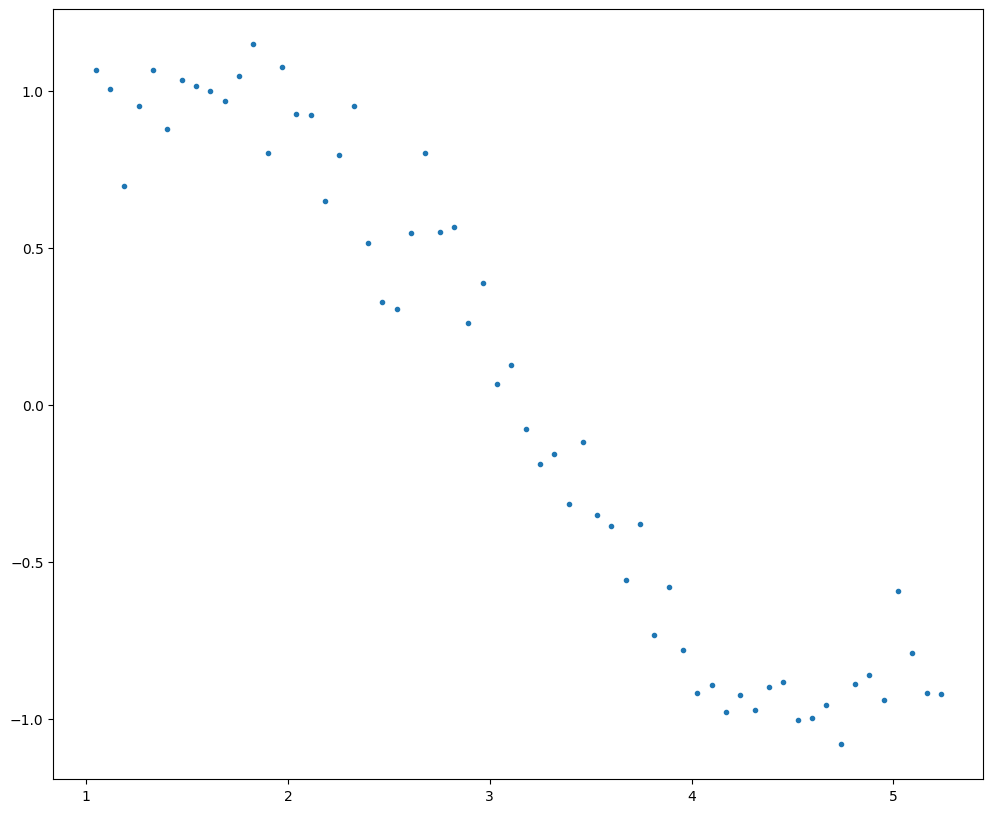

In [2]:
rcParams['figure.figsize'] = (12, 10)

np.random.seed(10)
x = np.linspace(np.radians(60), np.radians(300), 60)
y = np.sin(x) + np.random.normal(0, 0.15, len(x))

data = pd.DataFrame({'x': x, 'y': y})
plt.plot(data['x'],data['y'],'.')

Isso se assemelha a uma curva seno, mas não exatamente por causa do ruído.
Vamos tentar estimar a função seno usando regressão polinomial com potências de x de 1 a 15.

Vamos adicionar uma coluna para cada potência até 15 em nosso dataframe.

In [3]:
for i in range(2,16):
    colname = 'x_%d'%i
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.118194  1.006604  1.250358  1.398143  1.563395  1.748179  1.954803   
2  1.189190  0.696258  1.414174  1.681722  1.999888  2.378247  2.828189   
3  1.260187  0.950890  1.588071  2.001266  2.521969  3.178153  4.005066   
4  1.331183  1.064630  1.772049  2.358922  3.140158  4.180126  5.564514   

        x_7       x_8        x_9       x_10       x_11       x_12       x_13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.185849  2.444203   2.733093   3.056128   3.417344   3.821254   4.272903   
2  3.363256  3.999551   4.756228   5.656061   6.726134   7.998654   9.511923   
3  5.047132  6.360330   8.015204  10.100655  12.728713  16.040558  20.214100   
4  7.407388  9.860591  13.126255  17.473451  23.260367  30.963813  41.218512   

        x_14       x_15  
0   1.907219   1.997235  
1   4.777934   5

Agora que temos todas as 15 potências, vamos criar 15 modelos de regressão linear diferentes, com cada modelo contendo variáveis com potências de x de 1 até o número específico do modelo. Por exemplo, o conjunto de características do modelo 8 será - {x, x_2, x_3, ..., x_8}.

Primeiro, definiremos uma função genérica que recebe a potência máxima requerida de x como entrada e retorna uma lista contendo - [RSS do modelo, intercepto, coef_x, coef_x2, ... até a potência inserida]. Aqui, RSS refere-se a 'Soma Residual dos Quadrados', que não é nada além da soma do quadrado dos erros entre os valores previstos e reais no conjunto de dados de treinamento.
Observe que esta função não irá plotar o ajuste do modelo para todas as potências, mas retornará o RSS e os coeficientes para todos os modelos.

Agora, podemos criar todos os 15 modelos e comparar os resultados. Para facilitar a análise, armazenaremos todos os resultados em um dataframe Pandas e plotaremos 6 modelos para ter uma ideia da tendência.

In [4]:
def create_predictors(power):
  predictors = ['x']
  if power >= 2:
    predictors.extend(['x_%d' % i for i in range(2, power + 1)])
  return predictors


'''
    função *create_predictors*(power) que está abaixo, gera uma lista de nomes de variáveis preditoras para um modelo de regressão polinomial,
    onde o grau máximo do polinômio é determinado pelo parâmetro power.
    Essa lista é essencial para criar o DataFrame com as features necessárias para o modelo.
'''

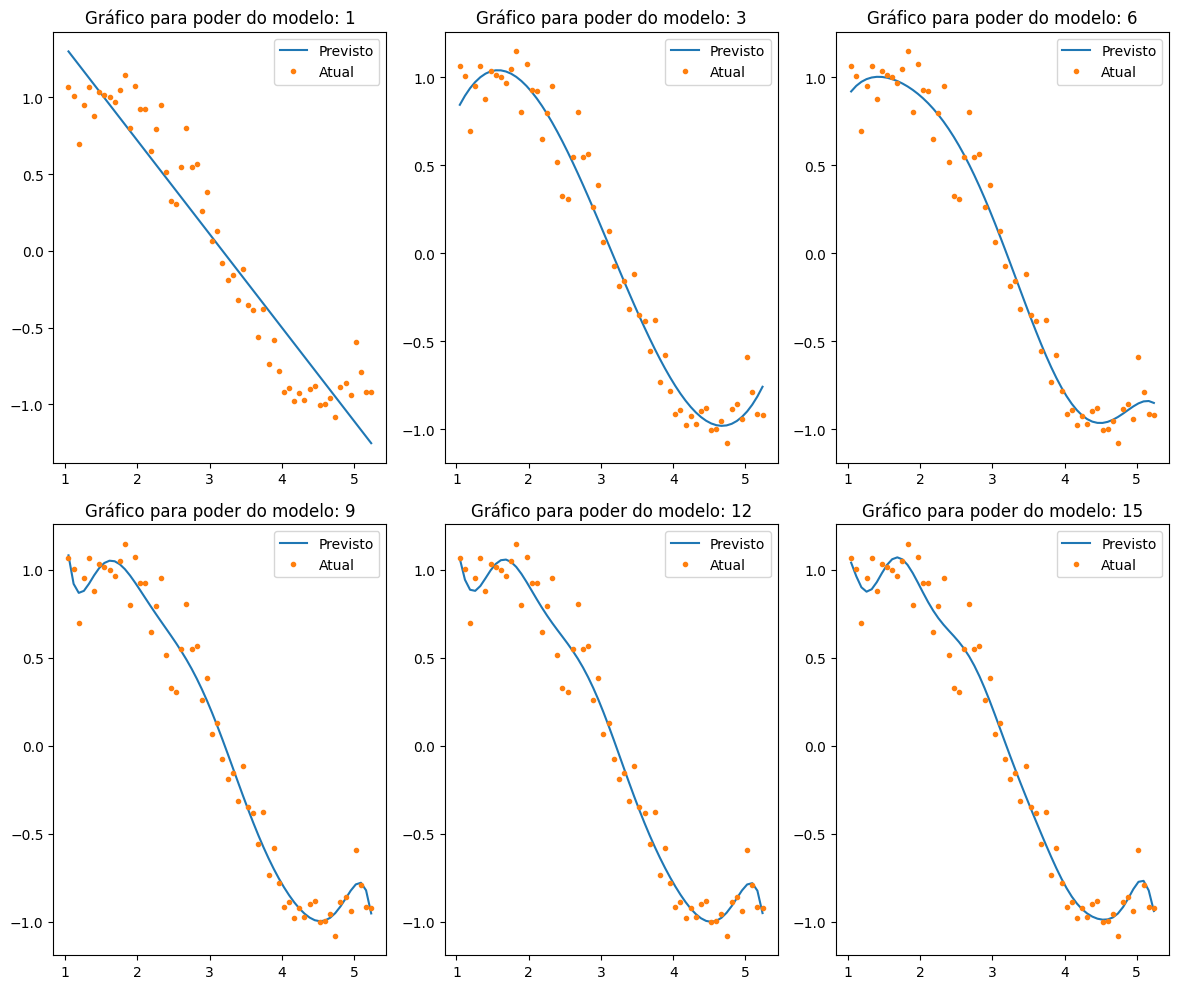

In [14]:
def fit_and_evaluate_model(data, power, models_to_plot=None):
  predictors = create_predictors(power)
  linreg = LinearRegression()
  linreg.fit(data[predictors], data['y'])
  y_pred = linreg.predict(data[predictors])

  rss = sum((y_pred - data['y'])**2)
  intercept = linreg.intercept_
  coefs = linreg.coef_.tolist()

  if models_to_plot and power in models_to_plot:
    plt.subplot(models_to_plot[power])
    plt.tight_layout()
    plt.plot(data['x'], y_pred, label='Previsto')
    plt.plot(data['x'], data['y'], '.', label='Atual')
    plt.title(f'Gráfico para poder do modelo: {power}')
    plt.legend()

  return [rss, intercept] + coefs

col = ['rss', 'intercept'] + ['coef_x_%d' % i for i in range(1, 16)]
ind = ['poder_mod_%d' % i for i in range(1, 16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1: 231, 3: 232, 6: 233, 9: 234, 12: 235, 15: 236}

for power in range(1, 16):
  coef_matrix_simple.iloc[power - 1, 0:power + 2] = fit_and_evaluate_model(data, power, models_to_plot)


'''
      A função fit_and_evaluate_model automatiza o processo de ajuste, avaliação e plotagem opcional para modelos de regressão linear com diferentes graus de polinômio. Isso permite a comparação de diferentes modelos e a escolha do melhor para o cenário específico.

      A função fit_and_evaluate_model é usada dentro de um loop para avaliar modelos de regressão linear com diferentes graus de polinômio (de 1 a 15).

      Primeiramente, é criado um DataFrame vazio (coef_matrix_simple) para armazenar os resultados de cada modelo.
      Um dicionário (models_to_plot) é definido para mapear potências específicas a subplots específicos na plotagem final (se desejado).

      O loop itera de 1 a 15 (potências de 1 a 15).
      Para cada iteração, a função fit_and_evaluate_model é chamada com os dados (data), a potência atual (power) e o dicionário de plotagem (models_to_plot).
      O retorno da função é usado para preencher a linha correspondente no DataFrame (coef_matrix_simple).

'''

Esperaríamos que os modelos com complexidade crescente se ajustassem melhor aos dados e resultassem em valores de RSS mais baixos. Isso pode ser verificado observando os gráficos gerados para 6 modelos.

Isso claramente se alinha com nosso entendimento inicial. À medida que a complexidade do modelo aumenta, os **modelos tendem a se ajustar** até mesmo a desvios menores no conjunto de dados de treinamento. Embora isso leve a overfitting, vamos deixar essa questão de lado por algum tempo e voltar ao nosso objetivo principal, ou seja, o impacto na magnitude dos coeficientes.

In [15]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
poder_mod_1,3.5,1.9,-0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_2,3.5,2,-0.65,0.0064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_4,1.1,-0.34,1.8,-0.62,-0.014,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_5,1,2.9,-4.9,4.5,-1.8,0.32,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_6,0.99,-2.6,9,-9,4.8,-1.4,0.21,-0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_7,0.93,18,-53,64,-41,15,-3.2,0.36,-0.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_8,0.92,41,-1.3e+02,1.7e+02,-1.2e+02,53,-14,2.2,-0.19,0.0067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_9,0.87,1.6e+02,-5.7e+02,8.9e+02,-7.7e+02,4.2e+02,-1.5e+02,33,-4.6,0.37,-0.013,NaN,NaN,NaN,NaN,NaN,NaN
poder_mod_10,0.87,1.3e+02,-4.5e+02,6.7e+02,-5.5e+02,2.7e+02,-79,13,-0.73,-0.12,0.022,-0.0011,NaN,NaN,NaN,NaN,NaN


É claramente evidente que o tamanho dos coeficientes aumenta exponencialmente com o aumento da complexidade do modelo. Compare os coeficientes de Potência 2 com os de Potência 15.

## **O que um coeficiente grande significa? (Potência 2 ou 3 ou 4)**

Significa que estamos dando muita ênfase a essa característica, ou seja, a característica particular é um bom preditor para o resultado.
Quando fica muito grande, o algoritmo começa a modelar relações intrincadas para estimar a saída e acaba superajustando-se aos dados de treinamento específicos.

## **Regressão Ridge (L2)**
A regressão Ridge realiza 'regularização L2', ou seja, adiciona um fator de soma dos quadrados dos coeficientes no objetivo de otimização.

Assim, a regressão ridge otimiza o seguinte: Objetivo = RSS + α * (soma do quadrado dos coeficientes)
Aqui, α (alfa) é o parâmetro que equilibra a quantidade de ênfase dada à minimização do RSS versus a minimização da soma do quadrado dos coeficientes.

α pode assumir vários valores:

 * α = 0: O objetivo se torna igual à regressão linear simples. Obteremos os mesmos coeficientes da regressão linear simples.

 * α = ∞: Os coeficientes serão zero. Por quê? Devido ao peso infinito no quadrado dos coeficientes, qualquer coisa menor que zero tornará o objetivo infinito.

 * 0 < α < ∞: A magnitude de α decidirá o peso dado às diferentes partes do objetivo. Os coeficientes estarão entre 0 e os da regressão linear simples.

Isso dá uma ideia de como α impactaria a magnitude dos coeficientes. Uma coisa é certa: qualquer valor diferente de zero daria valores menores que os da regressão linear simples.

Observe a função 'Ridge' usada aqui.

 * Ela recebe 'alfa' como parâmetro na inicialização.

 * Além disso, lembre-se que normalizar as entradas geralmente é uma boa ideia em qualquer tipo de regressão e deve ser usada no caso da regressão ridge também.

Agora, vamos analisar o resultado da regressão Ridge para 10 valores diferentes de α variando de 1e-15 a 20. Esses valores foram escolhidos para que possamos analisar facilmente a tendência com a mudança dos valores de α. No entanto, eles podem diferir de caso para caso.

**Nota**: Cada um desses 10 modelos conterá todas as 15 variáveis e apenas o valor de alpha será diferente

Isso é diferente do caso da regressão linear simples, onde cada modelo tinha um subconjunto de características.

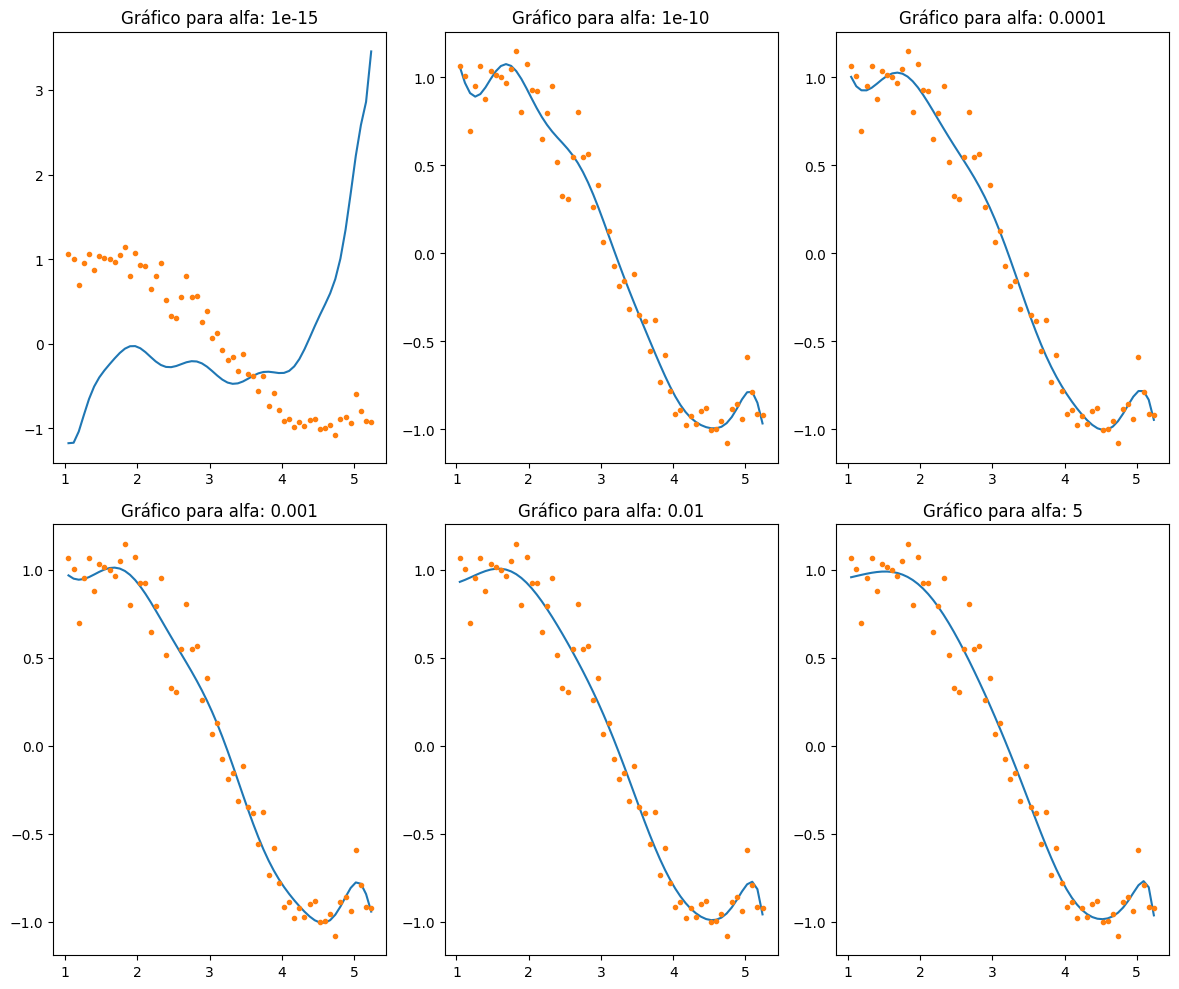

In [13]:
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    # Ajuste o modelo
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])

    # Verifica se um gráfico deve ser feito para o alfa inserido
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Gráfico para alfa: %.3g'%alpha)

    # Retorne o resultado em formato predefinido
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

# Inicialize os preditores para serem definidos com 15 potências de x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

# Define os diferentes valores de alfa a serem testados
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

# Inicialize o dataframe para armazenar coeficientes.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)


'''
A função *ridge_regression*(data, predictors, alpha, models_to_plot={}) automatiza o processo de ajuste, avaliação e plotagem opcional para modelos de regressão Ridge com diferentes valores de alpha. Isso permite a escolha do melhor valor de alpha para o cenário específico, analisando o impacto da regularização nos resultados.

### **Parâmetros**:

 * data: Um DataFrame contendo as features (colunas) e a variável alvo ('y').
 * predictors: Lista de nomes das features preditoras (geralmente criada externamente).
 * alpha: Valor do parâmetro de regularização alpha.
 * models_to_plot: Dicionário opcional que mapeia valores de alpha para números de subplot para plotagem (padrão: {}).

### Retorno:

Uma lista contendo o Residual Sum of Squares (RSS), intercepto e coeficientes do modelo ajustado.

### Funcionamento:

Ajuste do modelo:

 * Cria um objeto Ridge da biblioteca scikit-learn com o valor de alpha especificado.
 * Ajusta o modelo usando o método fit com as features (data[predictors]) e a variável alvo (data['y']).
 * Prediz os valores para a variável alvo usando o método predict com as features.

'''


 * Aqui, podemos observar claramente que, à medida que o valor de alpha aumenta, a complexidade do modelo reduz.
 * Embora valores mais altos de alpha reduzam o overfitting, valores significativamente altos também podem causar underfitting (por exemplo, alpha = 5).
 * Portanto, alpha deve ser escolhido com sabedoria. Uma técnica amplamente aceita é a validação cruzada, ou seja, o valor de alpha é iterado em uma faixa de valores e aquele que fornece uma pontuação de validação cruzada mais alta é escolhido.

In [8]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,1.3e+02,-2.6e+04,1.8e+05,-5.5e+05,1e+06,-1.3e+06,1.1e+06,-7.4e+05,3.7e+05,-1.4e+05,3.9e+04,-8.5e+03,1.4e+03,-1.6e+02,12,-0.57,0.012
alpha_1e-10,0.85,1.5e+02,-9.6e+02,2.5e+03,-3.1e+03,9.6e+02,2.4e+03,-4.1e+03,3.4e+03,-1.8e+03,6.8e+02,-1.8e+02,34,-4.5,0.4,-0.021,0.00049
alpha_1e-08,0.87,-12,80,-1.2e+02,-19,1.5e+02,-46,-1.4e+02,2e+02,-1.3e+02,53,-15,2.8,-0.37,0.031,-0.0015,3.4e-05
alpha_0.0001,0.89,6.4,-6.1,-3.4,2.3,4.2,0.038,-3.8,-0.14,3.6,-3,1.3,-0.33,0.053,-0.0053,0.0003,-7.5e-06
alpha_0.001,0.91,2.5,-1.4,-1.1,0.13,0.93,0.53,-0.49,-0.55,0.38,0.18,-0.27,0.12,-0.03,0.0042,-0.00032,1.1e-05
alpha_0.01,0.93,1.1,-0.24,-0.17,0.07,0.22,0.1,-0.14,-0.11,0.075,0.055,-0.069,0.03,-0.0072,0.00098,-7.3e-05,2.3e-06
alpha_1,0.94,0.86,0.0076,0.019,0.029,0.029,0.013,-0.012,-0.023,-0.0016,0.022,-0.014,0.0038,-0.00045,4.2e-07,4.7e-06,-3e-07
alpha_5,0.95,0.92,0.0036,0.0083,0.013,0.014,0.0092,-0.00042,-0.0087,-0.0065,0.0041,0.0042,-0.0042,0.0015,-0.00029,2.7e-05,-1.1e-06
alpha_10,0.95,0.93,0.0026,0.006,0.0092,0.01,0.0077,0.00066,-0.0065,-0.0062,0.0026,0.0047,-0.0041,0.0014,-0.00026,2.4e-05,-9.4e-07
alpha_20,0.95,0.95,0.0017,0.004,0.0063,0.0075,0.0061,0.0015,-0.0043,-0.0057,0.00053,0.0057,-0.0042,0.0014,-0.00025,2.3e-05,-8.7e-07


Isso imediatamente nos dá as seguintes inferências:
 * O RSS aumenta com o aumento de alpha, esta complexidade do modelo reduz
 * Um alpha tão pequeno quanto 1e-15 nos dá uma redução significativa na magnitude dos coeficientes. Como? Compare os coeficientes na primeira linha desta tabela com a última linha da tabela de regressão linear simples.
 * Valores altos de alpha podem levar a um underfitting significativo. Observe o rápido aumento do RSS para valores de alpha maiores que 1
 * Embora os coeficientes sejam muito pequenos, eles NÃO são zero.

Os primeiros 3 são muito intuitivos. Mas o 4° também é uma observação crucial.

 Vamos reconfirmar o mesmo determinando o número de zeros em cada linha do conjunto de dados de coeficientes:

In [9]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

,0
alpha_1e-15,0
alpha_1e-10,0
alpha_1e-08,0
alpha_0.0001,0
alpha_0.001,0
alpha_0.01,0
alpha_1,0
alpha_5,0
alpha_10,0
alpha_20,0


## **Regressão Lasso**
LASSO significa *Least Absolute Shrinkage and Selection Operator* (**Operador de Encolhimento e Seleção Mínimo Absoluto**).

Existem 2 palavras-chave aqui - '**absolute**' e '**selection**'.

A regressão Lasso realiza regularização L1, ou seja, adiciona um fator de soma do valor absoluto dos coeficientes no objetivo de otimização.

Assim, a regressão Lasso otimiza o seguinte:
 * Objetivo = RSS + α * (soma do valor absoluto dos coeficientes)
 * Aqui, α (alfa) funciona de forma semelhante à do Ridge e fornece uma troca entre equilibrar RSS e magnitude dos coeficientes. Como o Ridge, α pode assumir vários valores. Vamos iterá-lo brevemente aqui:
 * α = 0: Mesmos coeficientes que a regressão linear simples
 * α = ∞: Todos os coeficientes zero (mesma lógica de antes)
 * 0 < α < ∞: coeficientes entre 0 e os da regressão linear simples

Observe os parâmetros adicionais definidos na função Lasso - 'max_iter'.

Este é o número máximo de iterações para as quais queremos que o modelo seja executado se não convergir antes.
Isso também existe para Ridge, mas definir isso para um valor mais alto que o padrão foi necessário neste caso.

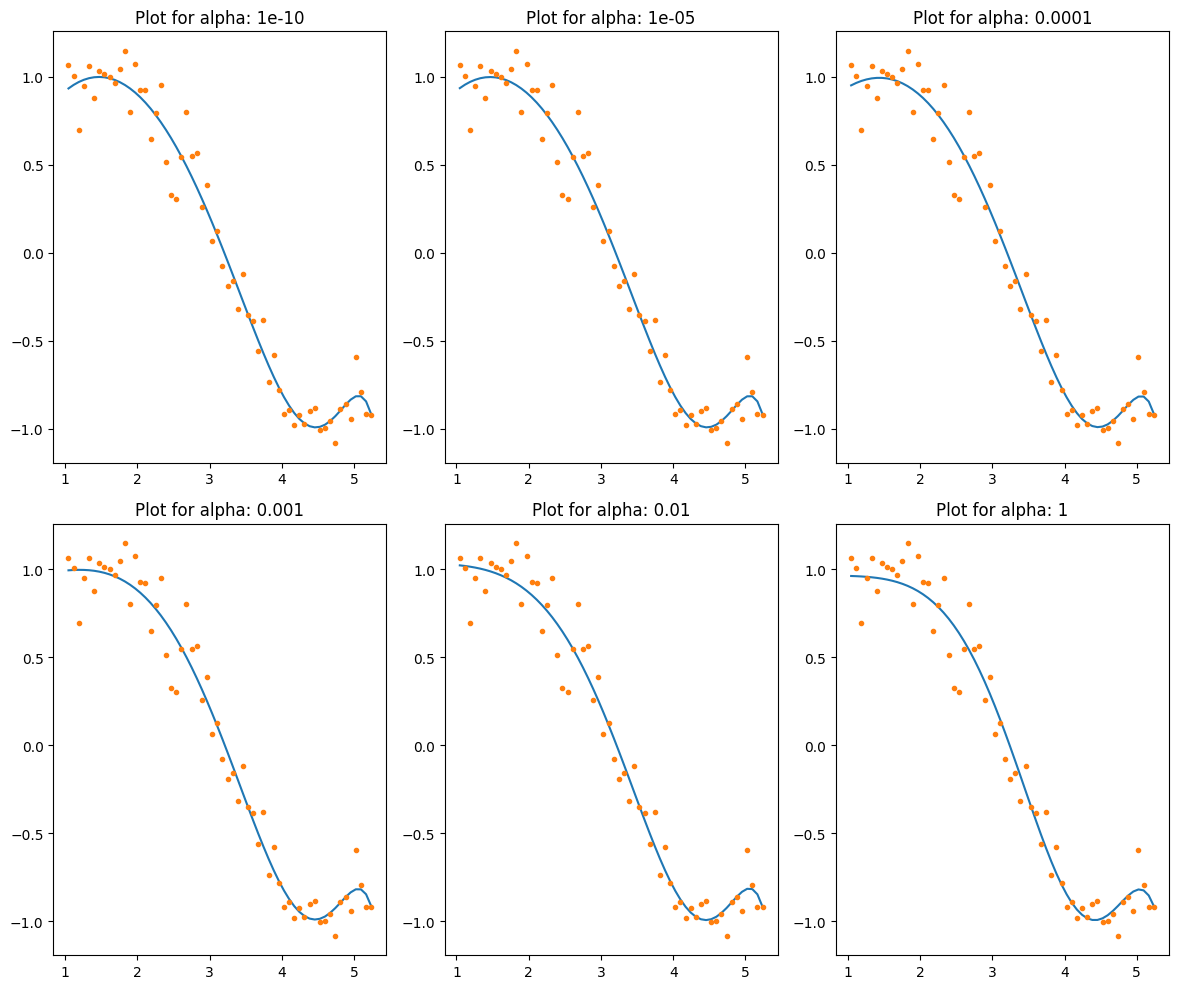

In [10]:
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    # Ajuste o modelo
    lassoreg = Lasso(alpha=alpha, max_iter=int(1e5))
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])

    # Verifica se um gráfico deve ser feito para o alfa inserido
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)

    # Retorna o resultado em formato predefinido
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

# Inicialize os preditores para serem definidos com 15 potências de x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

# Definindo os valores alfa para testar
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# Inicialize o dataframe para armazenar coeficientes
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

# Defina os modelos a serem plotados
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

# Itere sobre os 10 valores alfa:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)


'''

      A função *lasso_regression*(data, predictors, alpha, models_to_plot={}) ajusta um modelo de regressão LASSO, calcula métricas e opcionalmente
      plota os resultados para um dado valor de alpha.

      Parâmetros:

      * data: Um DataFrame contendo as features (colunas) e a variável alvo ('y').
      * predictors: Lista de nomes das features preditoras (geralmente criada externamente).
      * alpha: Valor do parâmetro de regularização alpha.
      * models_to_plot: Dicionário opcional que mapeia valores de alpha para números de subplot para plotagem (padrão: {}).

      Retorno:

      Uma lista contendo o Residual Sum of Squares (RSS), intercepto e coeficientes do modelo ajustado.

      Ajuste do modelo:

      * Cria um objeto Lasso da biblioteca scikit-learn com o valor de alpha especificado e um número máximo de iterações (opcional, para evitar loops infinitos).
      * Ajusta o modelo usando o método fit com as features (data[predictors]) e a variável alvo (data['y']).
      * Prediz os valores para a variável alvo usando o método predict com as features.

      * Calcula o RSS.
      * Constrói uma lista com o RSS, o intercepto e todos os coeficientes do modelo ajustado.
      * Retorna a lista contendo os resultados.


      A regressão LASSO difere da Ridge em como aplica a penalidade de regularização. LASSO usa o valor absoluto dos coeficientes, o que pode levar alguns coeficientes a serem
      reduzidos a zero. Isso resulta em um modelo mais esparso, onde algumas features podem ser completamente descartadas.

'''

Isso novamente nos diz que a complexidade do modelo diminui com o aumento dos valores de alpha.

Mas observe a linha reta em alpha=1. Parece um pouco estranho para mim. Vamos explorar isso mais a fundo olhando os coeficientes:

In [11]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.96,0.19,1.1,-0.39,0.0015,0.002,-4.9e-05,-5.4e-05,-5.7e-06,1.2e-06,6.6e-07,1.8e-07,3.4e-08,4.5e-09,1.5e-10,-1.6e-10,-7.4e-11
alpha_1e-10,0.96,0.19,1.1,-0.39,0.0015,0.002,-4.9e-05,-5.4e-05,-5.7e-06,1.2e-06,6.6e-07,1.8e-07,3.4e-08,4.5e-09,1.5e-10,-1.6e-10,-7.4e-11
alpha_1e-08,0.96,0.19,1.1,-0.39,0.0015,0.002,-4.9e-05,-5.4e-05,-5.7e-06,1.2e-06,6.6e-07,1.8e-07,3.4e-08,4.5e-09,1.5e-10,-1.6e-10,-7.4e-11
alpha_1e-05,0.96,0.23,1.1,-0.36,-0.0047,0.002,7.1e-06,-4.8e-05,-5.3e-06,1.2e-06,6.5e-07,1.7e-07,3.3e-08,4.4e-09,1.5e-10,-1.6e-10,-7.4e-11
alpha_0.0001,0.96,0.51,0.57,-0.084,-0.06,0.0026,0.0005,1.3e-05,-2.2e-06,7.4e-07,4.9e-07,1.4e-07,2.9e-08,4e-09,1.6e-10,-1.4e-10,-6.9e-11
alpha_0.001,0.97,0.95,0,0.086,-0.024,-0.017,0.00093,0.00026,2.5e-05,1.9e-06,2.1e-07,5e-08,1.2e-08,1.8e-09,2e-11,-1.1e-10,-5e-11
alpha_0.01,0.99,1,0,0,0,-0.0058,-0.0032,0.00027,7.7e-05,7.5e-06,5.1e-07,8.1e-09,-5.1e-09,-1.4e-09,-3.5e-10,-1e-10,-3.2e-11
alpha_1,1,0.97,-0,-0,-0,-0,-0,-0.0021,0.00013,8.6e-05,2.5e-06,-5.3e-07,-1.5e-07,-2.3e-08,-2.3e-09,6e-11,1e-10
alpha_5,1.2,0.91,-0,-0,-0,-0,-0,-0.00054,-0.00044,7.2e-05,1.7e-05,1.3e-07,-1.9e-07,-4.3e-08,-5.3e-09,-1.5e-10,1.6e-10
alpha_10,1.3,0.89,-0,-0,-0,-0,-0,-0,-0.00054,1.3e-05,3e-05,6.6e-07,-2.3e-07,-5.8e-08,-7.7e-09,-2.7e-10,2.2e-10


Além da inferência esperada de RSS mais alto para alphas mais altos, podemos ver o seguinte:
 * Para os mesmos valores de alpha, os coeficientes da regressão lasso são muito menores em comparação com os da regressão ridge (compare a linha 1 das 2 tabelas).
 * Para o mesmo alpha, lasso tem RSS mais alto (ajuste mais pobre) em comparação com a regressão ridge
 * Muitos dos coeficientes são zero mesmo para valores muito pequenos de alpha
 * As inferências # 1,2 podem não se generalizar sempre, mas serão válidas para muitos casos. A diferença real em relação ao ridge está saindo na última inferência.

In [12]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

,0
alpha_1e-15,0
alpha_1e-10,0
alpha_1e-08,0
alpha_1e-05,0
alpha_0.0001,0
alpha_0.001,1
alpha_0.01,3
alpha_1,5
alpha_5,5
alpha_10,6


Podemos observar que mesmo para um valor pequeno de alpha, um número significativo de coeficientes é zero.

Isso também explica o ajuste da linha horizontal para alpha=1 nos gráficos lasso, é apenas um modelo de linha de base!

Esse fenômeno de a maioria dos coeficientes ser zero é chamado de 'esparsidade'.

Embora o lasso realize seleção de recursos, esse nível de esparsidade é alcançado apenas em casos especiais, que discutiremos no final.

Isso tem algumas implicações realmente interessantes nos casos de uso da regressão lasso em comparação com a regressão ridge.